This notebook is experimenting with two methods of structure optimization: singular value decomposition (SVD) and soft filter pruning (SFP).

The idea of the SVD method is shown in the picture below: the weights of each layer are decomposed into three matrices, then training takes place with additional restrictions on maintaining the orthogonality of the matrices and the sparseness of singular values. After training, the least significant singular numbers and the corresponding rows and columns in orthogonal matrices are pruned. Thus, it is possible to achieve a significant reduction in the number of parameters. During the forward pass, the product of these matrices is calculated, which corresponds to the weight matrix of the original dimension.

![Singular value decomposition](../../docs/img/SVD.png)

The idea of the SVD method is shown in the picture below: after each training epoch, the significance of each filter in the convolutional layer is evaluated, then the least significant filters are set to zero. This procedure is repeated after each training epoch. At the end, unnecessary filters are completely removed from the mozhel.

![Soft filter pruning](../../docs/img/SFP.png)

In [1]:
import sys

sys.path.append('../..')

You can download Land-Use Scene Classification dataset [here](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification).
The first step is to prepare the dataset in the pytorch Dataset format.

In [2]:
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder

dataset_path =  # your path to dataset

transform = Compose([ToTensor(), Resize((256, 256))])
train_dataset = ImageFolder(root=dataset_path + 'train', transform=transform)
val_dataset = ImageFolder(root=dataset_path + 'validation', transform=transform)

In the cell below, we define the parameters of the experiments to be carried out: an experiment without structure optimization, experiments with a singular value decomposition of convolutional layers, and experiments with soft filter pruning.

If you want to use a pre-trained model, you can set weights parameter like `weights=<your path to state dict>`.

If you don't want to reproduce experiments, you can skip this cell.

In [4]:
energy_thresholds = [
    0.1, 0.3, 0.5, 0.7, 0.9,
    0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
    0.992, 0.994, 0.996, 0.998, 0.999,
    0.9999, 1
]
optimizations = {
    'none': [{}],
    'SVD': [
        {
            'decomposing_mode': 'spatial',
            'orthogonal_loss_factor': 10,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
        {
            'decomposing_mode': 'channel',
            'orthogonal_loss_factor': 10,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
        {
            'decomposing_mode': 'spatial',
            'orthogonal_loss_factor': 100,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
        {
            'decomposing_mode': 'channel',
            'orthogonal_loss_factor': 100,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
    ],
    'SFP': [
        {
            'pruning_ratio': 0.5,
            'finetuning_epochs': 5
        },
        {
            'pruning_ratio': 0.7,
            'finetuning_epochs': 5
        },
        {
            'pruning_ratio': 0.8,
            'finetuning_epochs': 5
        },
        {
            'pruning_ratio': 0.9,
            'finetuning_epochs': 5
        },
    ]
}

In the cell below, we run experiments for 100 epochs.

If you do not want to reproduce experiments, you can skip this cell.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import warnings
warnings.filterwarnings("ignore")

import torch
from core.operation.utils.cv_experimenters import ClassificationExperimenter


for optimization, params_list in optimizations.items():
    for params in params_list:
        experimenter = ClassificationExperimenter(
            dataset_name='Land-Use_Scene_Classification',
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            num_classes=21,
            dataloader_params={'batch_size': 32, 'num_workers': 4},
            model='ResNet18',
            model_params={},
            models_saving_path='models',
            optimizer=torch.optim.Adam,
            optimizer_params={},
            target_loss=torch.nn.CrossEntropyLoss,
            loss_params={},
            target_metric='f1',
            structure_optimization=optimization,
            structure_optimization_params=params,
            summary_path='runs',
            summary_per_class=True,
            gpu=True
        )
        experimenter.fit(100)

If you want to use our trained model, you can use the code from the cell below, preloading the weights [here](https://niuitmo-my.sharepoint.com/:f:/g/personal/avlitvintseva_niuitmo_ru/Ein_oioXxvpGgdIHOHc35M0ByA7ILw8-iYo2mjLaeCfpzw?e=BJc6mC).

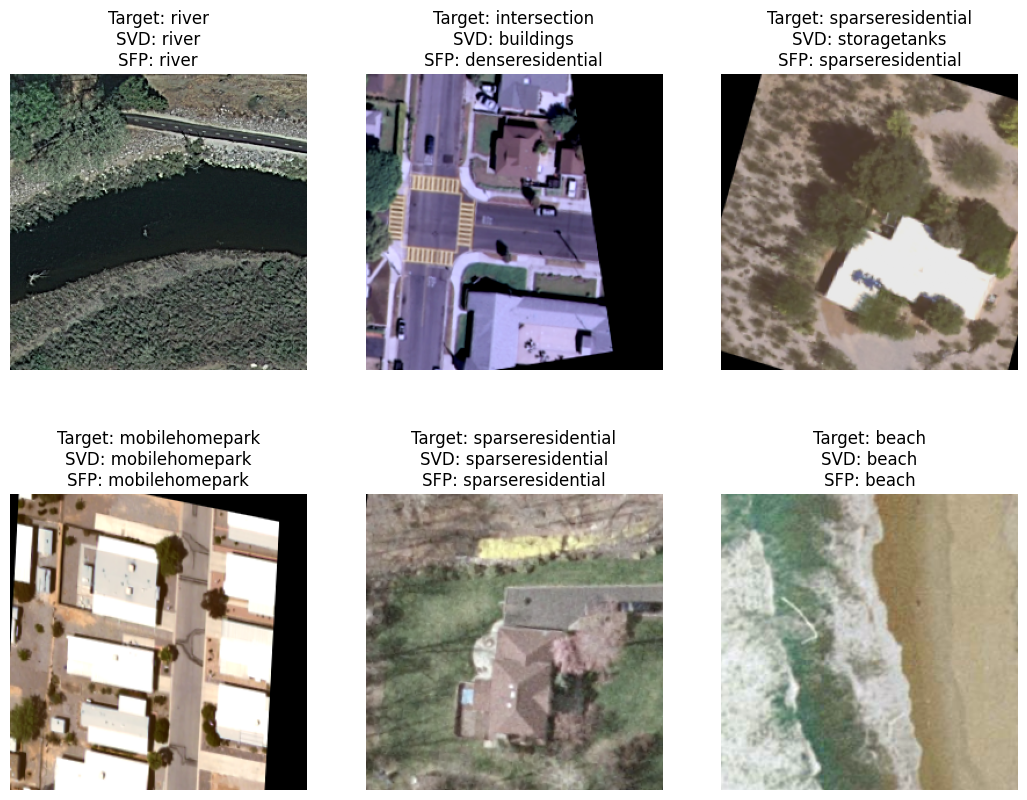

In [27]:
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from core.operation.utils.svd_tools import load_svd_state_dict
from core.operation.utils.sfp_tools import load_sfp_rsnet_model
from matplotlib import pyplot as plt

dl = DataLoader(val_dataset, batch_size=6, shuffle=True)
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

svd_state_dict_path = 'models/Land-Use_Scene_Classification/ResNet18_SVD_channel_O-100.0_H-0.001000/fine-tuning_e_0.998.sd.pt'
svd_model = resnet18(num_classes=21)
load_svd_state_dict(svd_model, decomposing_mode='channel', state_dict_path=svd_state_dict_path)

sfp_state_dict_path = 'models/Land-Use_Scene_Classification/ResNet18_SFP_P-0.50/fine-tuning.sd.pt'
sfp_model = load_sfp_rsnet_model('ResNet18', num_classes=21, state_dict_path=sfp_state_dict_path, pruning_ratio=0.5)


images, targets = next(iter(dl))
svd_preds = svd_model(images)
sfp_preds = sfp_model(images)

fig = plt.figure(figsize=(13, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].numpy().transpose((1,2,0)))
    plt.axis('off')
    plt.title(f'Target: {idx_to_class[targets[i].item()]}\nSVD: {idx_to_class[svd_preds.argmax(1)[i].item()]}\nSFP: {idx_to_class[sfp_preds.argmax(1)[i].item()]}')

Top models by metrics.

In [33]:
import pandas as pd
from visualization_utils import parse_experiment_folder

train_scores, svd_scores, sfp_scores = parse_experiment_folder('runs/Land-Use_Scene_Classification')
results = pd.DataFrame([train_scores['val/f1'].max(axis=0),
                        train_scores['val/accuracy'].max(axis=0),
                        train_scores['train/accuracy'].max(axis=0)],
                       index=['F1', 'validation accuracy', 'train accuracy']
                       ).T.sort_values('F1', ascending=False)
results

,F1,validation accuracy,train accuracy
ResNet18,0.934703,0.935238,1.000000
ResNet18_SFP_P-0.50,0.929713,0.930000,0.999864
ResNet18_SVD_spatial_O-100.0_H-0.001000,0.911742,0.912381,0.992935
ResNet18_SFP_P-0.70,0.907076,0.908095,0.994022
ResNet18_SVD_spatial_O-10.0_H-0.001000,0.900310,0.900000,0.992799
ResNet18_SVD_channel_O-100.0_H-0.001000,0.897529,0.898095,0.990353
ResNet18_SVD_channel_O-10.0_H-0.001000,0.895134,0.896190,0.990353
ResNet18_SFP_P-0.80,0.866985,0.866667,0.986821
ResNet18_SFP_P-0.90,0.150773,0.215714,0.786771


Run the next cells to visualize the results.

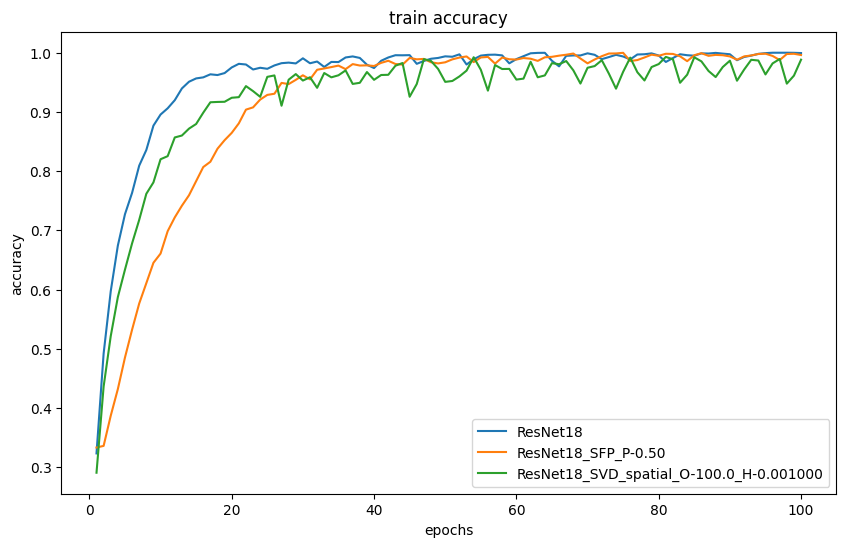

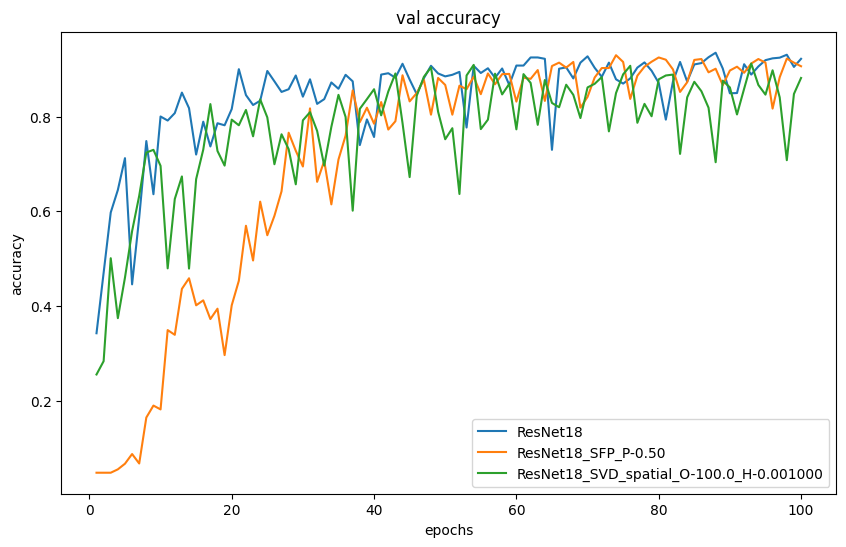

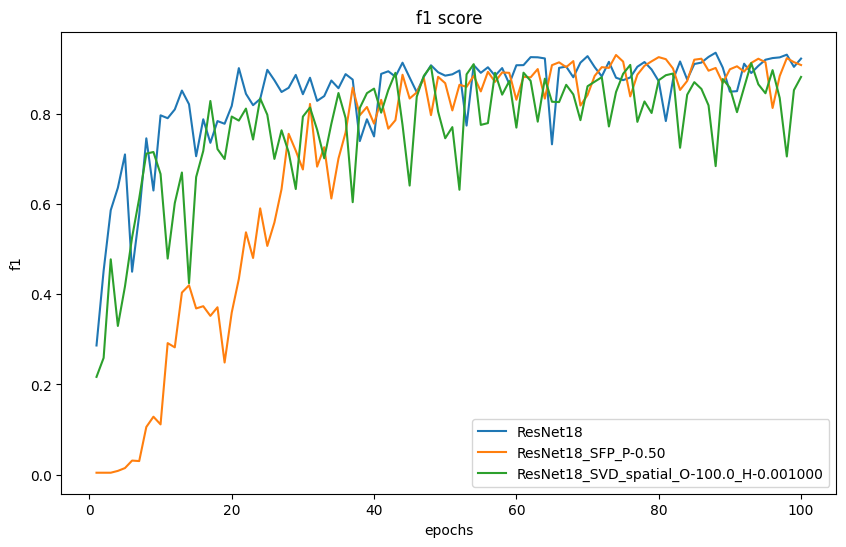

In [34]:
train_scores['train/accuracy'][['ResNet18', 'ResNet18_SFP_P-0.50', 'ResNet18_SVD_spatial_O-100.0_H-0.001000']].plot(
    figsize=(10, 6),
    title='train accuracy',
    xlabel='epochs',
    ylabel='accuracy'
)
train_scores['val/accuracy'][['ResNet18', 'ResNet18_SFP_P-0.50', 'ResNet18_SVD_spatial_O-100.0_H-0.001000']].plot(
    figsize=(10, 6),
    title='val accuracy',
    xlabel='epochs',
    ylabel='accuracy'
)
train_scores['val/f1'][['ResNet18', 'ResNet18_SFP_P-0.50', 'ResNet18_SVD_spatial_O-100.0_H-0.001000']].plot(
    figsize=(10, 6),
    title='f1 score',
    xlabel='epochs',
    ylabel='f1'
);

The table below shows how the values of the SFP model metric change after pruning and fine-tuning. The quality loss is due to the presence of BachNorm layers in the ResNet architecture. However, additional training for 5 epochs leads not only to compensation for losses, but also to an increase in the value of the target metric.

In [35]:
sfp_scores['f1']

,ResNet18_SFP_P-0.50,ResNet18_SFP_P-0.70,ResNet18_SFP_P-0.80,ResNet18_SFP_P-0.90
default_scores,0.929713,0.907076,0.866985,0.150773
pruned_scores,0.919227,0.906703,0.864732,0.129550
finetuned_scores,0.931301,0.915815,0.876054,0.702590


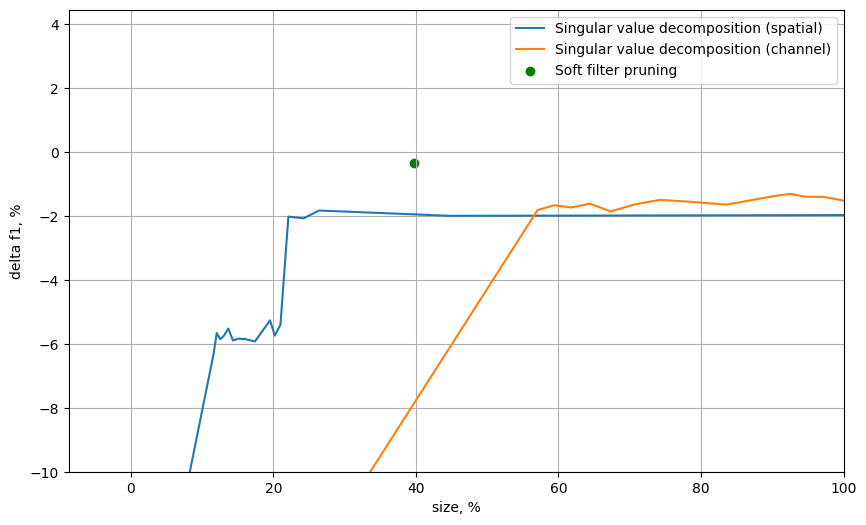

In [36]:
from matplotlib import pyplot as plt

baseline_f1 = results.loc['ResNet18', 'F1']
svd_scores['delta f1, %'] = (svd_scores['abs(e)/f1'] - baseline_f1) / baseline_f1 * 100
sfp_scores['delta f1, %'] = (sfp_scores['f1'] - baseline_f1) / baseline_f1 * 100
sfp_scores['size, %'] = sfp_scores['size'] / sfp_scores['size'].loc['default_scores'] * 100

plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('size, %')
plt.ylabel('delta f1, %')
plt.plot(
    svd_scores['percentage(e)/size']['ResNet18_SVD_spatial_O-100.0_H-0.001000_fine-tuned'],
    svd_scores['delta f1, %']['ResNet18_SVD_spatial_O-100.0_H-0.001000_fine-tuned'],
    label='Singular value decomposition (spatial)')
plt.plot(
    svd_scores['percentage(e)/size']['ResNet18_SVD_channel_O-100.0_H-0.001000_fine-tuned'],
    svd_scores['delta f1, %']['ResNet18_SVD_channel_O-100.0_H-0.001000_fine-tuned'],
    label='Singular value decomposition (channel)')
plt.scatter(
    sfp_scores['size, %'].loc['finetuned_scores', 'ResNet18_SFP_P-0.50'],
    sfp_scores['delta f1, %'].loc['finetuned_scores', 'ResNet18_SFP_P-0.50'],
    label=f'Soft filter pruning',
    color='green'
)
plt.xlim(right=100)
plt.ylim(bottom=-10)
plt.legend();

The last graph shows the dependence of the loss in the target metric on the change in the size of the model. The $y$ value is calculated as $\frac{F_{1 model} - F_{1 baseline}}{F_{1 baseline}}$ and the $x$ value as $\frac{size_{model} }{size_{baseline}}$.

 Models trained using soft filter pruning optimization can be pruned in the only way, models trained using singular value decomposition optimization can be pruned in a variety of ways, so that an acceptable trade-off can be found between loss of recognition quality and model size.